In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import shutil
import os
import time
from PIL import Image
from numba import jit
import pickle
from pathlib import Path
import skimage.measure
%matplotlib inline

from keras.optimizers import Adam

from keras.models import load_model
from sklearn import metrics

/home/lzmoraes/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Functions

In [3]:
# check the nth ('n') of an integer 'num'
def check_nth_bit(num, n):
    return (num>>n)&1

# flip the bit of the integer 'int' at a position 'p'  (staring at 0)
def bitflip(int,p):
    mask = 1 << p
    return (int^ mask)

# count the numbers of 1 on a binarie representetion of an interger n
def CountBits(n):
    n = (n & 0x5555555555555555) + ((n & 0xAAAAAAAAAAAAAAAA) >> 1)
    n = (n & 0x3333333333333333) + ((n & 0xCCCCCCCCCCCCCCCC) >> 2)
    n = (n & 0x0F0F0F0F0F0F0F0F) + ((n & 0xF0F0F0F0F0F0F0F0) >> 4)
    n = (n & 0x00FF00FF00FF00FF) + ((n & 0xFF00FF00FF00FF00) >> 8)
    n = (n & 0x0000FFFF0000FFFF) + ((n & 0xFFFF0000FFFF0000) >> 16)
    n = (n & 0x00000000FFFFFFFF) + ((n & 0xFFFFFFFF00000000) >> 32) 
    return n

# defining n!
@jit
def factorial(n):
    if n == 0:
        return 1
    else:
        return n * factorial(n-1)

# finding the states that have the maginetization "z"
@jit
def statep(y,z):
    a = 0
    for x in range(0,2**l):
        if (2* CountBits(x)-l) == z:
            y[a] = x
            a += 1
    return (y)

# numbers of states with magnatization x
def num_mag(x):
    y = p = int(factorial(l)//((factorial((x+l)/2))*(factorial(l -((x+l)/2)))))
    return y
            
# find the position in the list of states "s" that are iqual to "b"
@jit
def find_state(s,b):
    for z in range(0,p+1):
        if s[z] == b:
            return(z)

# power method
@jit
def power_iteration(A):
    # Choose a random vector
    y_0 = np.random.rand(A.shape[0])
    #erro precision
    e= 0.000000001
    #convergence constant
    er= 1.0
    it = 0
    while (er >= e):
        # calculate the matrix-by-vector product Ab
        z_1 = np.dot(A, y_0)
        # calculate the norm
        z_1_norm = np.linalg.norm(z_1)
        # renormalize the vector
        y_1 = z_1 / z_1_norm
        z_2 = np.dot(A, y_1)
        z_2_norm = np.linalg.norm(z_2)
        lamb_1 = np.dot(z_2,y_1)/np.dot(y_1,y_1)
        y_2 = z_2/z_2_norm
        z_3 = np.dot(A, y_2)
        z_3_norm = np.linalg.norm(z_3)
        lamb_2 = np.dot(z_3,y_2)/np.dot(y_2,y_2)
        er = abs(lamb_1 - lamb_2)/abs(lamb_2)
        y_0 = z_3/z_3_norm
        it += 1
        #if( it%10 == 0):print('# of interations:',it,';','Precision:', er)
    return (y_0, lamb_2)

@jit
def POWER_METHOD(A,dim):
    for x in range(0,dim):
        A[x,x] -= 2*l
        
    C = np.asarray(power_iteration(A))
    C[1] += 2*l
    return (C)

def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.title('RMSE ='+ str(np.round(100000*score)/100000))
    plt.savefig('predct_pool.png')
    plt.show()
    
#plt.switch_backend('agg')

def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'mean_squared_error' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'val_mean_squared_error' in s and 'val' in s]

    if len(loss_list) == 0:
        print('Loss is missing in history')
        return

    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)

    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))

    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.savefig('loss_retrain_pool.png')
    plt.show()
    

    ## Accuracy
    #plt.figure(2)
    #for l in acc_list:
        #plt.plot(epochs, history.history[l], 'b', label='Training Mean Square Error (' + str(format(history.history[l][-1],'.5f'))+')')
    #for l in val_acc_list:
        #plt.plot(epochs, history.history[l], 'g', label='Validation Mean Square Error (' + str(format(history.history[l][-1],'.5f'))+')')

    #plt.title('Mean Square Error')
    #plt.xlabel('Epochs')
    #plt.ylabel('Mean Square Error')
    #plt.legend()
    

# Retrain random local MF

In [4]:
path_folder = 'matrix_del_rand/'
ex = '.npy'

if not os.path.exists(path_folder):
    os.mkdir(path_folder)

c_i = 8.

l = 8
j = 1
delt = -1

row = []
for i in range(0,1000):
    
    h = c_i*np.random.randn(l)
    
    Hxxz = np.zeros((2**l , 2**l ))

    # constructing the full xxz hamiltonian (2^L, 2^L) 
    for x in range(0,2**l):
        for y in range(0,l):
            k = (y+1)%l
            if check_nth_bit(x,y) == 0:
                Hxxz[x,x] += -j*h[y]/2
            else:
                Hxxz[x,x] += j*h[y]/2
            #if y != l-1:    
            if check_nth_bit(x,y) == check_nth_bit(x,k):
                Hxxz[x,x] += -(j*delt)/2
            else:
                Hxxz[x,x] += (j*delt)/2
                b = bitflip(x,y)
                c = bitflip(b,k)
                Hxxz[x,c] += -j
    #print(Hxxz)
       
    
    mag_array = np.zeros(l+1)
    E_array = np.zeros(l+1)
    a = 0
    for mag in range(-l,l+1,2):
    
        p = num_mag(mag)
        state = np.array(range(p))
        s = statep(state,mag)
        
        Hxxz_p = np.zeros((p,p))
        for x in range(0,p):
            for y in range(0,l):
                if check_nth_bit(s[x],y) == 0:
                    Hxxz_p[x,x] += -(j*h[y])/2
                else:
                    Hxxz_p[x,x] += (j*h[y])/2
                k = (y+1)%l
                #if y != l-1:
                if check_nth_bit(s[x],y) == check_nth_bit(s[x],k):
                    Hxxz_p[x,x] += -(j*delt)/2
                else:
                    Hxxz_p[x,x] += (j*delt)/2
                    b = bitflip(s[x],y)
                    c = bitflip(b,k)
                    D = np.where(s == c)
                    Hxxz_p[x,D] = -j
                                            
        #print(Hxxz_p)
        mag_array[a] = mag
        A = POWER_METHOD(Hxxz_p,p)
        E_array[a] = A[1] 
        psi_s = -mag_array[np.where(E_array == np.min(E_array))]
        a += 1
   
    row.append([str(i+1) + ex, np.min(E_array)/l])
    np.save(os.path.abspath(path_folder+str(i+1)), Hxxz)   
    #print('h:',h)
    #print('MAG_GS:', psi_s[0])
    #print('rhoE_array:', np.min(E_array)/l)
    
    
row = np.asarray(row)

data_set = pd.DataFrame(row)
data_set.to_csv("rand.csv")

dataset = pd.read_csv('rand.csv')


#writing the columns of the csv in an list
X_1 = dataset.iloc[:,1].values
Y_1 = dataset.iloc[:,2].values

W = np.random.permutation(np.c_[X_1.reshape(len(X_1), -1), Y_1.reshape(len(Y_1), -1)])

X = W[:, :X_1.size//len(X_1)].reshape(X_1.shape)
Y = W[:, X_1.size//len(X_1):].reshape(Y_1.shape)

x_train = np.array([X[i] for i in range((len(X)//10),len(X))])
y_train = np.array([Y[i] for i in range((len(Y)//10),len(Y))])

x_test = np.array([X[i] for i in range((len(X)//10))])
y_test = np.array([Y[i] for i in range((len(Y)//10))])

train_data = []

load_train_data = []
for file in x_train:
        path = os.path.abspath(path_folder+ file)
        H = np.load(path)
        load_train_data.append(H)
load_train_data = np.array(load_train_data)
train_data = load_train_data[:,:,:,np.newaxis]
train_data -= np.mean(train_data)
train_data /= np.std(train_data)

train_label = []
for file in y_train:
    train_label.append(file)
train_label = np.array(train_label)

test_data = []

load_test_data = []
for file in x_test:
        path = os.path.abspath(path_folder+ file)
        H = np.load(path)
        load_test_data.append(H)
load_test_data = np.array(load_test_data)
test_data = load_test_data[:,:,:,np.newaxis]
test_data -= np.mean(test_data)
test_data /= np.std(test_data)

test_label = []
for file in y_test:
    test_label.append(file)
test_label = np.array(test_label)

model = load_model('my_model.h5')

model.compile(Adam(lr=.0001),loss='mean_squared_error')


history = model.fit(train_data, train_label, epochs=15, batch_size=128, validation_split=0.1, verbose=1)

model.save('rand_train.h5')
plot_history(history)



pred = model.predict(test_data, batch_size=128)
score = np.sqrt(metrics.mean_squared_error(pred,test_label))
print("Score (RMSE): {}".format(score))

chart_regression(pred.flatten(),test_label)

Train on 810 samples, validate on 90 samples
Epoch 1/15
810/810 [==============================] - 312s 385ms/step - loss: 3.1581 - val_loss: 2.4006
Epoch 2/15
810/810 [==============================] - 308s 380ms/step - loss: 1.2121 - val_loss: 1.0751
Epoch 3/15
810/810 [==============================] - 309s 382ms/step - loss: 0.8816 - val_loss: 0.4052
Epoch 4/15
810/810 [==============================] - 307s 379ms/step - loss: 0.5133 - val_loss: 0.8422
Epoch 5/15
810/810 [==============================] - 309s 381ms/step - loss: 0.4040 - val_loss: 0.2562
Epoch 6/15
810/810 [==============================] - 308s 380ms/step - loss: 0.2748 - val_loss: 0.2883
Epoch 7/15
810/810 [==============================] - 308s 380ms/step - loss: 0.2436 - val_loss: 0.3408
Epoch 8/15
810/810 [==============================] - 307s 379ms/step - loss: 0.2301 - val_loss: 0.2240
Epoch 9/15
810/810 [==============================] - 308s 380ms/step - loss: 0.2178 - val_loss: 0.3001
Epoch 10/15
810/810

No handles with labels found to put in legend.


Score (RMSE): 0.37446958851517576


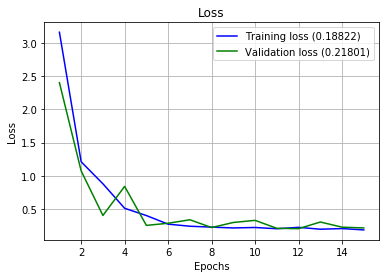

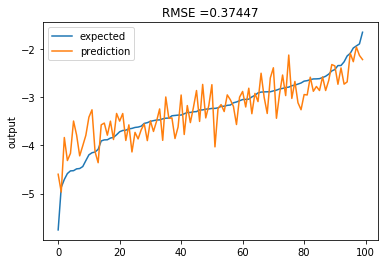

In [26]:
plot_history(history)
chart_regression(pred.flatten(),test_label)

# Retrain Pooling dimensions

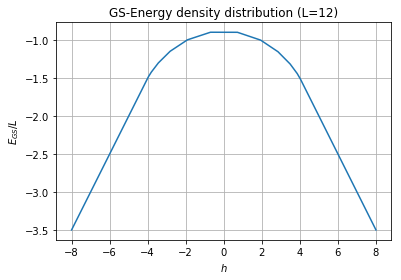

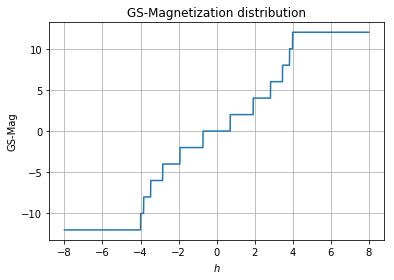

TypeError: must be str, not numpy.float64

In [33]:
# number of spins
l = 12

#dimension constant
j = 1

#anisotropy constant
delt = -1

path_folder = 'matrix_pool/'

if not os.path.exists(path_folder):
    os.mkdir(path_folder)
    
h = -8.
row = []
while h <= 8:
    
    Hxxz = np.zeros((2**l , 2**l ))

    # constructing the full xxz hamiltonian (2^L, 2^L) 
    for x in range(0,2**l):
        for y in range(0,l):
            k = (y+1)%l
            if check_nth_bit(x,y) == 0:
                Hxxz[x,x] += -j*h/2
            else:
                Hxxz[x,x] += j*h/2
            #if y != l-1:    
            if check_nth_bit(x,y) == check_nth_bit(x,k):
                Hxxz[x,x] += -(j*delt)/2
            else:
                Hxxz[x,x] += (j*delt)/2
                b = bitflip(x,y)
                c = bitflip(b,k)
                Hxxz[x,c] += -j

    
    
    mag_array = np.zeros(l+1)
    E_array = np.zeros(l+1)
    a = 0
    for mag in range(-l,l+1,2):
    
        p = num_mag(mag)
        state = np.array(range(p))
        s = statep(state,mag)
        
        Hxxz_p = np.zeros((p,p))
        for x in range(0,p):
            for y in range(0,l):
                if check_nth_bit(s[x],y) == 0:
                    Hxxz_p[x,x] += -(j*h)/2
                else:
                    Hxxz_p[x,x] += (j*h)/2
                k = (y+1)%l
                #if y != l-1:
                if check_nth_bit(s[x],y) == check_nth_bit(s[x],k):
                    Hxxz_p[x,x] += -(j*delt)/2
                else:
                    Hxxz_p[x,x] += (j*delt)/2
                    b = bitflip(s[x],y)
                    c = bitflip(b,k)
                    D = np.where(s == c)
                    Hxxz_p[x,D] = -j
                        #if mag == 0:
                            #print('[',x,D,']','k:',k,'s[x]:',s[x],'y:',y,'b:',b,'c:',c,'s[5]',s[5])
                    
        #print(Hxxz_p)
        mag_array[a] = mag
        A = POWER_METHOD(Hxxz_p,p)
        E_array[a] = A[1] 
        psi_s = -mag_array[np.where(E_array == np.min(E_array))]
        a += 1
    ex = '.npy'
    Hxxz_pool = skimage.measure.block_reduce(Hxxz,(16,16), np.average)
    np.save(os.path.abspath(path_folder + str(h)), Hxxz_pool)
    row.append([str(h) + ex, psi_s[0], np.min(E_array)/l, h])
            
        
    #print('h:',h)
    #print('MAG_GS:', psi_s[0])
    #print('rhoE_array:', np.min(E_array)/l)
    h += .01
    
row = np.asarray(row)

a_h = np.array(row[:,3]).astype(np.float) #h
b_e = np.array(row[:,2]).astype(np.float) #E_GS/l
c_m = np.array(row[:,1]).astype(np.float) #mag_GS

plt.plot(a_h,b_e,'-')
plt.title('GS-Energy density distribution (L='+str(l)+')')
plt.xlabel(r'$h$')
plt
plt.ylabel(r'$E_{GS}/L$')
plt.grid()
plt.savefig('GS-Energy_big.png')
plt.show()


plt.plot(a_h,c_m)
plt.title('GS-Magnetization distribution')
plt.xlabel(r'$h$')
plt.ylabel('GS-Mag')
plt.grid()
plt.savefig('GS-Mag_big.png')
plt.show()


data_set = pd.DataFrame(row)
data_set.to_csv("pool.csv")



Train on 1296 samples, validate on 145 samples
Epoch 1/15
1296/1296 [==============================] - 500s 385ms/step - loss: 2.2387 - val_loss: 2.7312
Epoch 2/15
1296/1296 [==============================] - 498s 384ms/step - loss: 1.5703 - val_loss: 0.6251
Epoch 3/15
1296/1296 [==============================] - 497s 384ms/step - loss: 0.4632 - val_loss: 0.3551
Epoch 4/15
1296/1296 [==============================] - 498s 384ms/step - loss: 0.2275 - val_loss: 0.2368
Epoch 5/15
1296/1296 [==============================] - 498s 385ms/step - loss: 0.1385 - val_loss: 0.0890
Epoch 6/15
1296/1296 [==============================] - 498s 384ms/step - loss: 0.0738 - val_loss: 0.0450
Epoch 7/15
1296/1296 [==============================] - 500s 386ms/step - loss: 0.0401 - val_loss: 0.0278
Epoch 8/15
1296/1296 [==============================] - 498s 385ms/step - loss: 0.0245 - val_loss: 0.0313
Epoch 9/15
1296/1296 [==============================] - 497s 384ms/step - loss: 0.0217 - val_loss: 0.0288

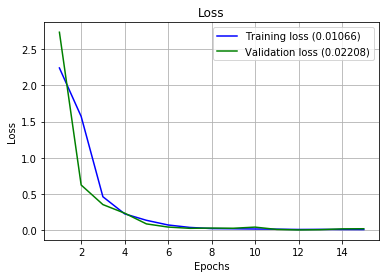

160/160 [==============================] - 18s 115ms/step
Score (RMSE): 0.10549530569528734


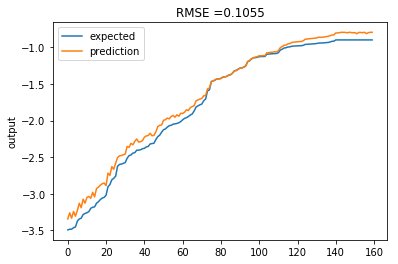

In [5]:
dataset = pd.read_csv('pool.csv')

path_folder = 'matrix_pool/'

#writing the columns of the csv in an list
X_1 = dataset.iloc[:,1].values
Y_1 = dataset.iloc[:,3].values

W = np.random.permutation(np.c_[X_1.reshape(len(X_1), -1), Y_1.reshape(len(Y_1), -1)])

X = W[:, :X_1.size//len(X_1)].reshape(X_1.shape)
Y = W[:, X_1.size//len(X_1):].reshape(Y_1.shape)

x_train = np.array([X[i] for i in range((len(X)//10),len(X))])
y_train = np.array([Y[i] for i in range((len(Y)//10),len(Y))])

x_test = np.array([X[i] for i in range((len(X)//10))])
y_test = np.array([Y[i] for i in range((len(Y)//10))])

train_data = []

load_train_data = []
for file in x_train:
        path = os.path.abspath(path_folder+ file)
        H = np.load(path)
        load_train_data.append(H)
load_train_data = np.array(load_train_data)
train_data = load_train_data[:,:,:,np.newaxis]
train_data -= np.mean(train_data)
train_data /= np.std(train_data)

train_label = []
for file in y_train:
    train_label.append(file)
train_label = np.array(train_label)

test_data = []

load_test_data = []
for file in x_test:
        path = os.path.abspath(path_folder+ file)
        H = np.load(path)
        load_test_data.append(H)
load_test_data = np.array(load_test_data)
test_data = load_test_data[:,:,:,np.newaxis]
test_data -= np.mean(test_data)
test_data /= np.std(test_data)

test_label = []
for file in y_test:
    test_label.append(file)
test_label = np.array(test_label)

model = load_model('my_model.h5')

model.compile(Adam(lr=.0001),loss='mean_squared_error')

history = model.fit(train_data, train_label, epochs=15, batch_size=128, validation_split=0.1, verbose=1)

model.save('pool_train.h5')
plot_history(history)

pred = model.predict(test_data, verbose=1)
score = np.sqrt(metrics.mean_squared_error(pred,test_label))
print("Score (RMSE): {}".format(score))

chart_regression(pred.flatten(),test_label)

# Retrain Pooling dimensions and random local MF

In [ ]:
# number of spins
l = 12

#dimension constant
j = 1

#anisotropy constant
delt = -1

path_folder = 'matrix_pool_rand/'

if not os.path.exists(path_folder):
    os.mkdir(path_folder)
    

row = []
for i in range(0,1000):
    
    h = np.random.randn(l)
    Hxxz = np.zeros((2**l , 2**l ))

    # constructing the full xxz hamiltonian (2^L, 2^L) 
    for x in range(0,2**l):
        for y in range(0,l):
            k = (y+1)%l
            if check_nth_bit(x,y) == 0:
                Hxxz[x,x] += -j*h[y]/2
            else:
                Hxxz[x,x] += j*h[y]/2
            #if y != l-1:    
            if check_nth_bit(x,y) == check_nth_bit(x,k):
                Hxxz[x,x] += -(j*delt)/2
            else:
                Hxxz[x,x] += (j*delt)/2
                b = bitflip(x,y)
                c = bitflip(b,k)
                Hxxz[x,c] += -j

    
    
    mag_array = np.zeros(l+1)
    E_array = np.zeros(l+1)
    a = 0
    for mag in range(-l,l+1,2):
    
        p = num_mag(mag)
        state = np.array(range(p))
        s = statep(state,mag)
        
        Hxxz_p = np.zeros((p,p))
        for x in range(0,p):
            for y in range(0,l):
                if check_nth_bit(s[x],y) == 0:
                    Hxxz_p[x,x] += -(j*h[y])/2
                else:
                    Hxxz_p[x,x] += (j*h[y])/2
                k = (y+1)%l
                #if y != l-1:
                if check_nth_bit(s[x],y) == check_nth_bit(s[x],k):
                    Hxxz_p[x,x] += -(j*delt)/2
                else:
                    Hxxz_p[x,x] += (j*delt)/2
                    b = bitflip(s[x],y)
                    c = bitflip(b,k)
                    D = np.where(s == c)
                    Hxxz_p[x,D] = -j
                        
                    
        #print(Hxxz_p)
        mag_array[a] = mag
        A = POWER_METHOD(Hxxz_p,p)
        E_array[a] = A[1] 
        psi_s = -mag_array[np.where(E_array == np.min(E_array))]
        a += 1
    ex = '.npy'
    Hxxz_pool = skimage.measure.block_reduce(Hxxz,(16,16), np.max)
    np.save(os.path.abspath(path_folder + str(h)), Hxxz_pool)
    row.append([str(h) + ex, psi_s[0], np.min(E_array)/l])
            
        
    #print('h:',h)
    #print('MAG_GS:', psi_s[0])
    #print('rhoE_array:', np.min(E_array)/l)
    
    
row = np.asarray(row)

data_set = pd.DataFrame(row)
data_set.to_csv("pool_rand.csv")

In [11]:
dataset = pd.read_csv('pool_rand.csv')

path_folder = 'matrix_pool_rand/'

#writing the columns of the csv in an list
X_1 = dataset.iloc[:,1].values
Y_1 = dataset.iloc[:,3].values

W = np.random.permutation(np.c_[X_1.reshape(len(X_1), -1), Y_1.reshape(len(Y_1), -1)])

X = W[:, :X_1.size//len(X_1)].reshape(X_1.shape)
Y = W[:, X_1.size//len(X_1):].reshape(Y_1.shape)

x_train = np.array([X[i] for i in range((len(X)//10),len(X))])
y_train = np.array([Y[i] for i in range((len(Y)//10),len(Y))])

x_test = np.array([X[i] for i in range((len(X)//10))])
y_test = np.array([Y[i] for i in range((len(Y)//10))])

train_data = []

load_train_data = []
for file in x_train:
        path = os.path.abspath(path_folder+ file)
        H = np.load(path)
        load_train_data.append(H)
load_train_data = np.array(load_train_data)
train_data = load_train_data[:,:,:,np.newaxis]
train_data -= np.mean(train_data)
train_data /= np.std(train_data)

train_label = []
for file in y_train:
    train_label.append(file)
train_label = np.array(train_label)

test_data = []

load_test_data = []
for file in x_test:
        path = os.path.abspath(path_folder+ file)
        H = np.load(path)
        load_test_data.append(H)
load_test_data = np.array(load_test_data)
test_data = load_test_data[:,:,:,np.newaxis]
test_data -= np.mean(test_data)
test_data /= np.std(test_data)

test_label = []
for file in y_test:
    test_label.append(file)
test_label = np.array(test_label)

Train on 810 samples, validate on 90 samples
Epoch 1/15
810/810 [==============================] - 313s 386ms/step - loss: 0.4557 - val_loss: 0.3618
Epoch 2/15
810/810 [==============================] - 310s 383ms/step - loss: 0.1587 - val_loss: 0.0180
Epoch 3/15
810/810 [==============================] - 310s 382ms/step - loss: 0.0400 - val_loss: 0.0512
Epoch 4/15
810/810 [==============================] - 310s 382ms/step - loss: 0.0210 - val_loss: 0.0069
Epoch 5/15
810/810 [==============================] - 311s 384ms/step - loss: 0.0119 - val_loss: 0.0197
Epoch 6/15
810/810 [==============================] - 310s 383ms/step - loss: 0.0079 - val_loss: 0.0029
Epoch 7/15
810/810 [==============================] - 310s 383ms/step - loss: 0.0071 - val_loss: 0.0099
Epoch 8/15
810/810 [==============================] - 310s 383ms/step - loss: 0.0054 - val_loss: 0.0023
Epoch 9/15
810/810 [==============================] - 311s 384ms/step - loss: 0.0057 - val_loss: 0.0059
Epoch 10/15
810/810

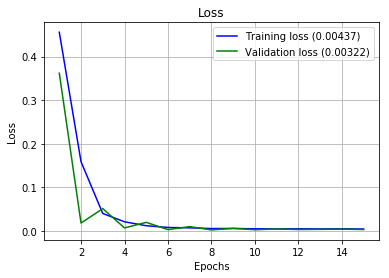

100/100 [==============================] - 12s 117ms/step
Score (RMSE): 0.055880651539055956


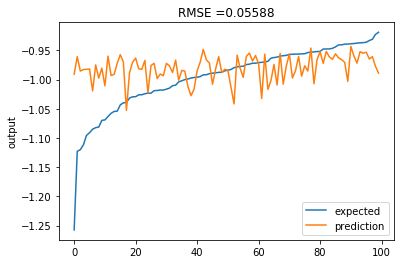

In [13]:
model = load_model('my_model.h5')

model.compile(Adam(lr=.0001),loss='mean_squared_error')

history = model.fit(train_data, train_label, epochs=15, batch_size=128, validation_split=0.1, verbose=1)

model.save('pool_rand_train.h5')
plot_history(history)

pred = model.predict(test_data, verbose=1)
score = np.sqrt(metrics.mean_squared_error(pred,test_label))
print("Score (RMSE): {}".format(score))

chart_regression(pred.flatten(),test_label)